In [79]:
from glob import glob
import numpy as np
import pyabf
import matplotlib.pyplot as plt
import matplotlib as mp
from open_abf import *
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from scipy.optimize import leastsq
%matplotlib widget

In [80]:
pathToData = "/home/alan/Documents/LAB/CSHL/Data/Good/juliana - striatum/"
files = glob(pathToData+"*.abf")
files

['/home/alan/Documents/LAB/CSHL/Data/Good/juliana - striatum/2024_06_21_0011.abf',
 '/home/alan/Documents/LAB/CSHL/Data/Good/juliana - striatum/2024_06_21_0014.abf',
 '/home/alan/Documents/LAB/CSHL/Data/Good/juliana - striatum/2024_06_21_0006.abf',
 '/home/alan/Documents/LAB/CSHL/Data/Good/juliana - striatum/2024_06_21_0036.abf',
 '/home/alan/Documents/LAB/CSHL/Data/Good/juliana - striatum/2024_06_21_0027.abf',
 '/home/alan/Documents/LAB/CSHL/Data/Good/juliana - striatum/2024_06_21_0007.abf',
 '/home/alan/Documents/LAB/CSHL/Data/Good/juliana - striatum/2024_06_21_0026.abf']

In [81]:
get_protocol(files)

['D1-D2_ramp',
 'D1-D2_current step',
 'D1-D2_current step',
 'D1-D2_current step',
 'D1-D2_current step',
 'D1-D2_current step',
 'D1-D2_current step']

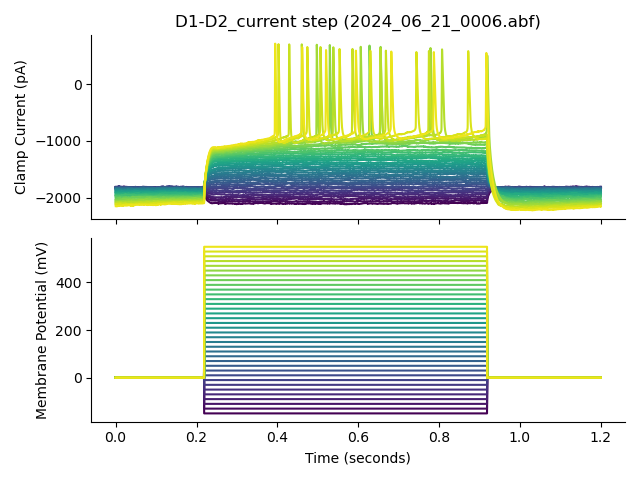

In [82]:
plt.close('all')
f = files[2]
plot_swps(f)

In [83]:
## Extract the sweeps
swps, swp_time, sr = get_sweeps(f)
## The mean on your current step:
i_start = 0.4
i_end = 0.8
current_step = np.mean(swp_window(swps,i_start,i_end,sr,channel=1),axis=1)
## The spiking part:
v_start = 0.22
v_end = 0.9186
voltage = swp_window(swps,v_start,v_end,sr,channel=0)

In [107]:

def kernel(dx, sigma):
    return np.exp(-dx**2/(2*sigma**2))


def smooth(x, sigma, ydata, xdata=None):
    x = np.array(x)
    if xdata is None:
        assert len(x)==np.array(ydata).shape[-1]
        xdata = x
    k = kernel(xdata[:,None]-x[None,:], sigma)
    ydim = np.array(ydata).ndim
    new_shape_k = tuple([1]*(ydim-1)) + k.shape
    k = np.reshape(k,new_shape_k)
    y = (k*ydata[...,None]).sum(-2)/k.sum(-2)
    return y
    
def spike_detect(volt, v_dt,
                 thr=-10, inf_bnd=3, sup_bnd=500,
                 ref_t=1e-3):
    if np.mean(volt) < -100:
        volt /= 20
    deriv = np.diff(volt)
    is_spk = (deriv[:-1]<2) * (deriv[1:]>=2)
    spikes = np.where(is_spk)[0]
    # refact = int(ref_t/v_dt)
    # ref = 0
    # sspk = []
    # for st in spikes:
    #     if st<ref:
    #         continue
    #     else:
    #         spk = volt[st:st+refact]
    #     if spk.max() < thr:
    #         continue
    #     else:
    #         sspk.append(st)
    #         ref = st+refact
    # sspk = np.array(sspk)
    spk_thrsh = np.mean(volt[spikes])
    stimes = spikes*v_dt
    isi = np.diff(stimes)
    inst_frq = 1/isi
    if spikes.shape == (0,):
        return [np.nan,np.nan]
    else:
        return np.mean(inst_frq),spk_thrsh

-39.454868861607146


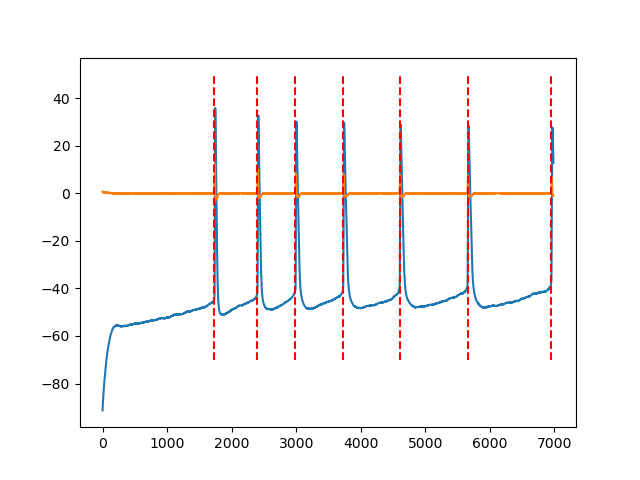

In [85]:
v = voltage[-1]/20
ref_t=1e-3
thr=-10
v_dt = 1/sr
deriv = np.diff(v)
fig,ax = plt.subplots()
ax.plot(v)
ax.plot(deriv)
is_spk = (deriv[:-1]<2) * (deriv[1:]>=2)
spikes = np.where(is_spk)[0]
stimes = spikes*v_dt
ax.vlines(spikes,-70,50,color='red',linestyle='dashed')
isi = np.diff(stimes)
inst_frq = 1/isi
print(np.mean(v[spikes]))

In [86]:
spikes

array([1734, 2400, 2989, ..., 4603, 5654, 6953])

In [92]:
res = []
thrsh = []
for v in voltage:
    sorting = spike_detect(v,1/sr)
    res.append(sorting[0])
    thrsh.append(sorting[1])

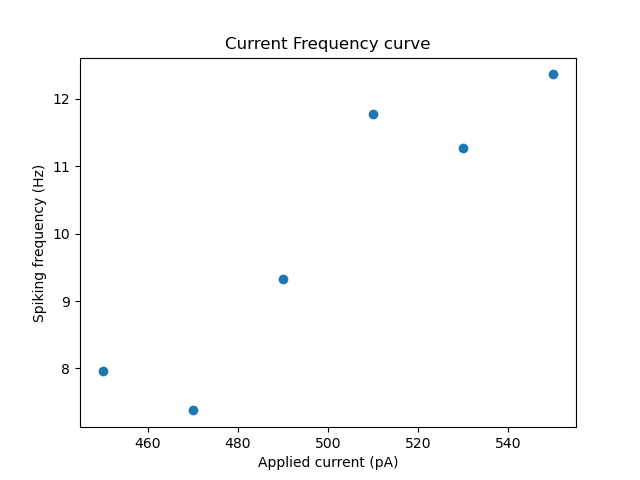

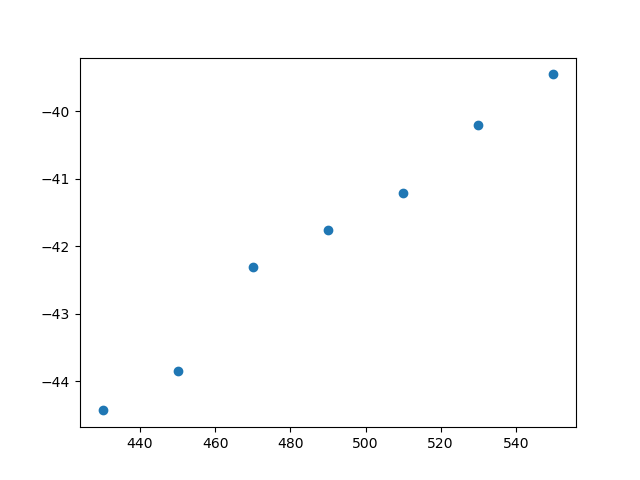

In [97]:
fig,ax = plt.subplots()
ax.set_title('Current Frequency curve')
ax.plot(current_step,res,'o')
ax.set_xlabel('Applied current (pA)')
ax.set_ylabel('Spiking frequency (Hz)')
fig,ax = plt.subplots()
ax.plot(current_step,thrsh,'o')

In [108]:
cell1 = files = glob(pathToData+"*006*.abf")[0]
cell2 = files = glob(pathToData+"*014*.abf")[0]
cell3 = files = glob(pathToData+"*026*.abf")[0]
cell4 = files = glob(pathToData+"*036*.abf")[0]
cells = [cell1,cell2,cell3,cell4]

In [109]:
cells

['/home/alan/Documents/LAB/CSHL/Data/Good/juliana - striatum/2024_06_21_0006.abf',
 '/home/alan/Documents/LAB/CSHL/Data/Good/juliana - striatum/2024_06_21_0014.abf',
 '/home/alan/Documents/LAB/CSHL/Data/Good/juliana - striatum/2024_06_21_0026.abf',
 '/home/alan/Documents/LAB/CSHL/Data/Good/juliana - striatum/2024_06_21_0036.abf']

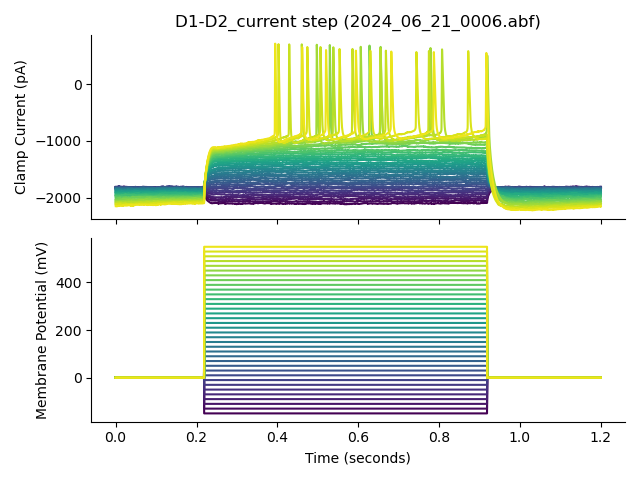

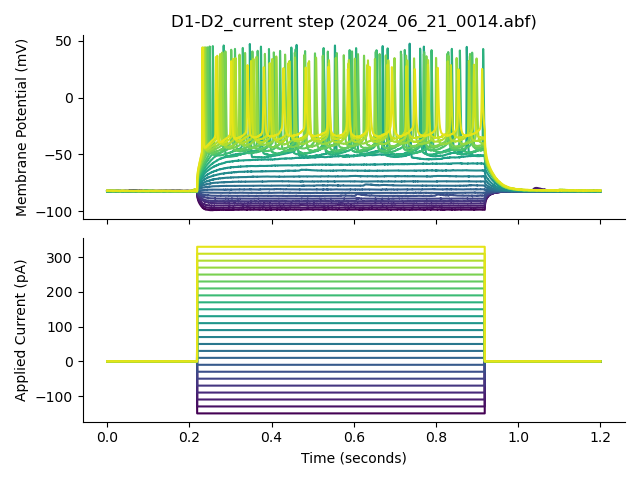

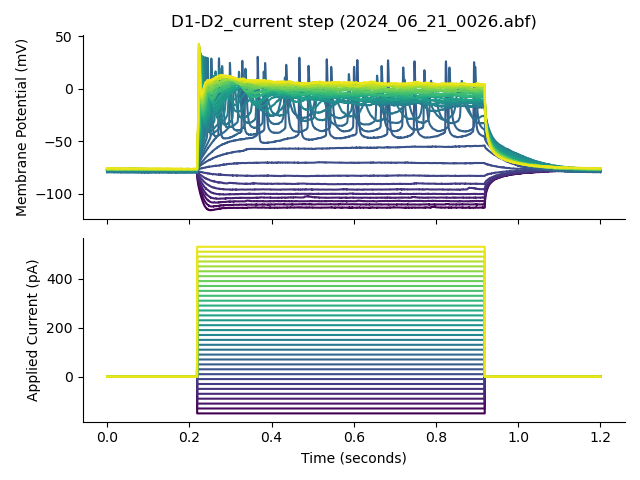

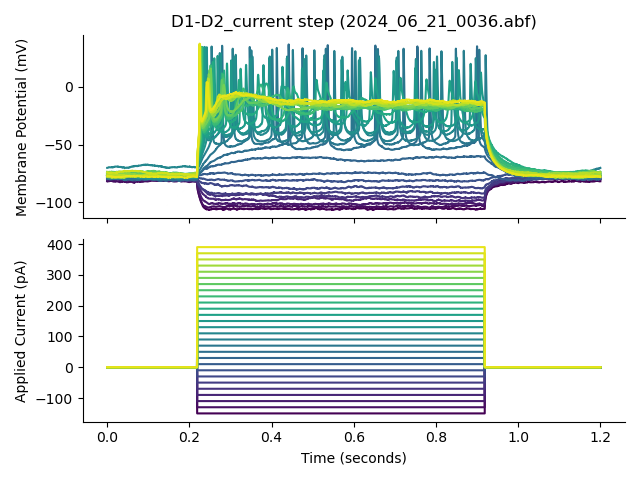

In [110]:
plt.close('all')
fi = []
for c in cells:
    swps, swp_time, sr = get_sweeps(c)
    plot_swps(c)
    ## The mean on your current step:
    i_start = 0.4
    i_end = 0.8
    current_step = np.mean(swp_window(swps,i_start,i_end,sr,channel=1),axis=1)
    ## The spiking part:
    v_start = 0.22
    v_end = 0.9186
    voltage = swp_window(swps,v_start,v_end,sr,channel=0)
    thrsh = []
    res = []
    for v in voltage:
        sorting = spike_detect(v,1/sr)
        res.append(sorting[0])
        thrsh.append(sorting[1])
    fi.append([current_step,res,thrsh])

In [111]:
len(cells)

4

In [116]:
np.nanmean(res[2])

-36.893064671308686

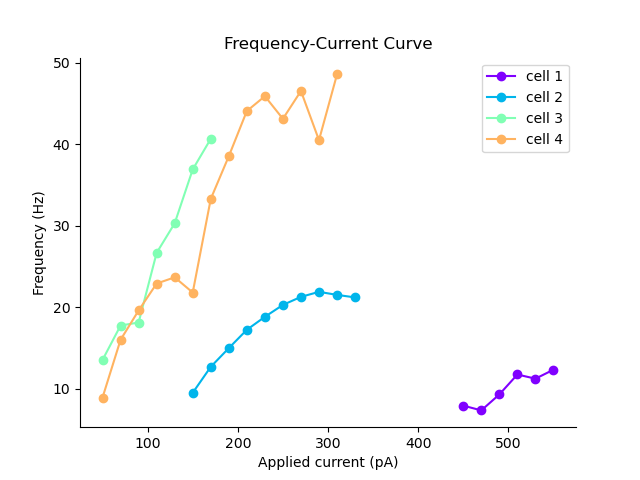

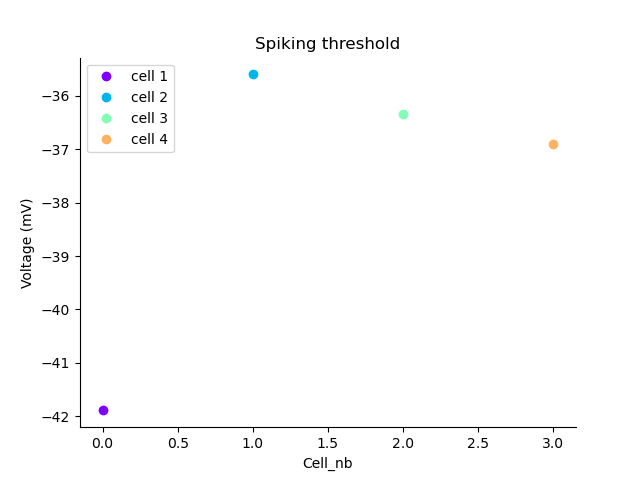

In [118]:
plt.close('all')
cmap = mp.colormaps['rainbow']
fig,ax = plt.subplots()
for i,res in enumerate(fi):
    color = cmap(i/len(cells))[:-1]
    ax.plot(res[0],res[1],'-o',color=color,label=f'cell {i+1}')
ax.set_title('Frequency-Current Curve')
ax.set_xlabel('Applied current (pA)')
ax.set_ylabel('Frequency (Hz)')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.legend()
fig,ax = plt.subplots()
for i,res in enumerate(fi):
    color = cmap(i/len(cells))[:-1]
    ax.plot(i,np.nanmean(np.array(res[2])),'o',color=color,label=f'cell {i+1}')
ax.set_title('Spiking threshold')
ax.set_xlabel('Cell_nb')
ax.set_ylabel('Voltage (mV)')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.legend()

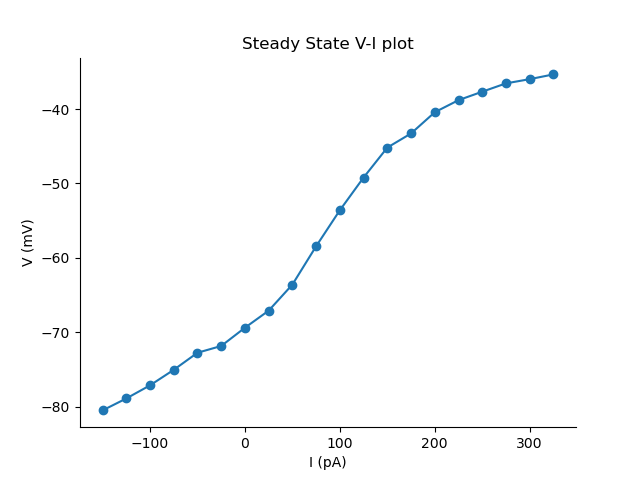

In [61]:
## Extract the sweeps
swps, swp_time, sr = get_sweeps(f)
## The mean on your current step:
i_start = 0.2
i_end = 1
current_step = np.mean(swp_window(swps,i_start,i_end,sr,channel=1),axis=1)
## The spiking part:
v_start = 1
v_end = 1.1
voltage = np.mean(swp_window(swps,v_start,v_end,sr,channel=0),axis=1)
fig,ax = plt.subplots()
ax.set_title('Steady State V-I plot')
ax.plot(current_step,voltage,'-o')
ax.set_ylabel('V (mV)')
ax.set_xlabel('I (pA)')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.show()

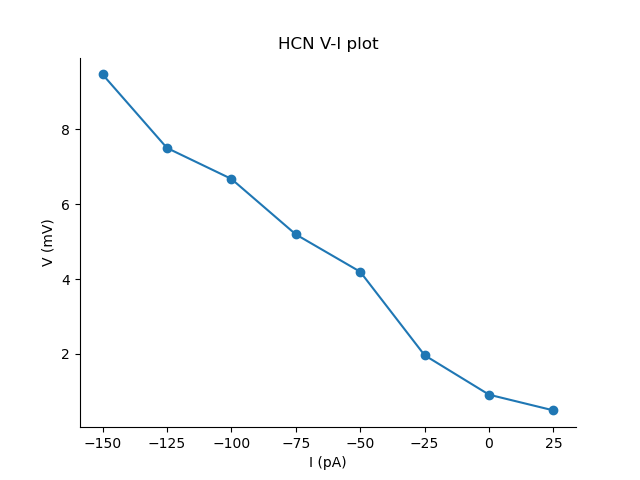

In [64]:
## Extract the sweeps
swps, swp_time, sr = get_sweeps(f)
## The mean on your current step:
i_start = 0.2
i_end = 1
current_step = np.mean(swp_window(swps,i_start,i_end,sr,channel=1),axis=1)
## The base part:
v_start = 1
v_end = 1.1
voltage = np.mean(swp_window(swps,v_start,v_end,sr,channel=0),axis=1)
## The base part:
v_start = 0.2
v_end = 0.6
sag = np.min(swp_window(swps,v_start,v_end,sr,channel=0),axis=1)
hcn = voltage - sag
fig,ax = plt.subplots()
ax.set_title('HCN V-I plot')
ax.plot(current_step[:8],hcn[:8],'-o')
ax.set_ylabel('V (mV)')
ax.set_xlabel('I (pA)')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.show()